<a href="https://colab.research.google.com/github/Xtian76/-MS-Progression-Prediction/blob/main/MSSEG_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
=============================================================================
TFM: Modelo Multimodal para Esclerosis Múltiple
SEMANA 1: Setup y Extracción de Features Clásicas
Dataset: Multiple Sclerosis 2016 (Longitudinal Data)
=============================================================================

INSTRUCCIONES:
1. Ejecuta las celdas en orden (Shift + Enter)
2. La primera vez tardará ~5 min en descargar el dataset
3. Al final tendrás un CSV con todas las features clásicas

OBJETIVO: Extraer biomarcadores tradicionales de las imágenes RM
Dataset: Incluye seguimiento temporal de pacientes (¡perfecto para TFM!)
"""

# =============================================================================
# CELDA 1: Instalación de librerías (ejecutar solo una vez)
# =============================================================================
print("📦 Instalando librerías necesarias...")
print("Esto puede tardar 2-3 minutos...\n")

!pip install -q nibabel nilearn SimpleITK
!pip install -q pandas numpy scikit-learn
!pip install -q xgboost shap matplotlib seaborn
!pip install -q scikit-image
!pip install -q openpyxl
!pip install -q kagglehub

print("✅ Instalación completada!")

# =============================================================================
# CELDA 2: Importar librerías
# =============================================================================
import os
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage
from skimage import measure
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("✅ Librerías importadas correctamente")
print(f"📍 Versiones:")
print(f"   - NumPy: {np.__version__}")
print(f"   - Pandas: {pd.__version__}")
print(f"   - Nibabel: {nib.__version__}")

# =============================================================================
# CELDA 3: Descargar dataset con kagglehub (SÚPER FÁCIL)
# =============================================================================
print("📥 Descargando dataset Multiple Sclerosis 2016...\n")
print("✅ VENTAJAS de este dataset:")
print("   • Datos LONGITUDALES (seguimiento temporal)")
print("   • Múltiples timepoints por paciente")
print("   • Perfecto para predecir progresión")
print("   • Descarga automática con kagglehub\n")

import kagglehub

# Descargar dataset (automático, sin necesidad de API key)
print("⏳ Descargando... (puede tardar 3-5 minutos)")
path = kagglehub.dataset_download("sasikumarg/multiple-sclerosis-2016")

print(f"\n✅ Dataset descargado en: {path}")

# Definir ruta del dataset
data_path = path

print(f"📂 Explorando contenido...")

📦 Instalando librerías necesarias...
Esto puede tardar 2-3 minutos...

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 132.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 180.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.9/295.9 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 12.2 MB/s eta 0:00:00
✅ Instalación completada!
✅ Librerías importadas correctamente
📍 Versiones:
   - NumPy: 2.0.2
   - Pandas: 2.2.2
   - Nibabel: 5.3.2
📥 Descargando dataset Multiple Sclerosis 2016...

✅ VENTAJAS de este dataset:
   • Datos LONGITUDALES (seguimiento temporal)
   • Múltiples timepoints por paciente


100%|██████████| 607M/607M [00:14<00:00, 42.9MB/s]

Extracting files...



✅ Dataset descargado en: /root/.cache/kagglehub/datasets/sasikumarg/multiple-sclerosis-2016/versions/2
📂 Explorando contenido...


In [ ]:
# List the contents of the downloaded dataset directory
print("📂 Contents of the dataset directory:")
print(os.listdir(data_path))

In [5]:
# =============================================================================
# CELDA 4: Explorar estructura del dataset
# =============================================================================
print("🔍 Explorando estructura del dataset...\n")

# Listar archivos
files_list = []

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith('.nii') or file.endswith('.nii.gz'):
            files_list.append(os.path.join(root, file))

print(f"📊 Total de archivos NIfTI encontrados: {len(files_list)}")

# Este dataset tiene estructura temporal (timepoint_01, timepoint_02, etc.)
# Vamos a organizar los datos por paciente y timepoint

patient_data = []

for filepath in files_list:
    filename = os.path.basename(filepath)

    # Identificar si es FLAIR o máscara
    if 'flair' in filename.lower():
        image_type = 'flair'
    elif 'consensus' in filename.lower():
        image_type = 'mask'
    elif 't1' in filename.lower():
        image_type = 't1'
    elif 't2' in filename.lower():
        image_type = 't2'
    elif 'dp' in filename.lower():
        image_type = 'dp'
    else:
        image_type = 'unknown'

    # Extraer información del path
    parts = filepath.split(os.sep)

    # Buscar patient ID en el nombre de la carpeta
    patient_id = None
    for part in parts:
        if 'patient' in part.lower():
            patient_id = part
            break # Assuming patient ID is the first part with 'patient'

    # Since there's no explicit timepoint in the folder/file structure,
    # we assume one timepoint per patient for this dataset.
    timepoint = 'timepoint_01'


    # Crear entrada solo si encontramos Patient ID y es un tipo de imagen conocido (FLAIR, Mask, T1, T2, DP)
    if patient_id and image_type != 'unknown':
        patient_data.append({
            'patient_id': patient_id,
            'timepoint': timepoint,
            'image_type': image_type,
            'filepath': filepath
        })

df_files = pd.DataFrame(patient_data)

# Organizar por paciente y timepoint
# Use pivot_table to handle multiple image types per patient/timepoint
df_organized = df_files.pivot_table(
    index=['patient_id', 'timepoint'],
    columns='image_type',
    values='filepath',
    aggfunc='first'  # Use first in case of duplicates (shouldn't happen with this structure)
).reset_index()


# Filtrar solo los que tienen FLAIR y máscara (these are essential for the next steps)
df_organized = df_organized[df_organized['flair'].notna() & df_organized['mask'].notna()]

print(f"\n✅ Datos organizados:")
print(f"   - Pacientes únicos: {df_organized['patient_id'].nunique()}")
print(f"   - Total de observaciones (paciente + timepoint): {len(df_organized)}")
print(f"   - Timepoints únicos: {df_organized['timepoint'].unique()}")

print("\n📋 Primeros registros:")
print(df_organized.head(10))

# Guardar organización para referencia
df_organized.columns.name = None
df_patients = df_organized.rename(columns={'flair': 'flair_path', 'mask': 'mask_path'})

print(f"\n📊 Distribución de timepoints por paciente:")
timepoints_per_patient = df_patients.groupby('patient_id').size()
print(f"   - Promedio: {timepoints_per_patient.mean():.1f} timepoints")
print(f"   - Máximo: {timepoints_per_patient.max()} timepoints")
print(f"   - Mínimo: {timepoints_per_patient.min()} timepoint(s)")

🔍 Explorando estructura del dataset...

📊 Total de archivos NIfTI encontrados: 50

✅ Datos organizados:
   - Pacientes únicos: 10
   - Total de observaciones (paciente + timepoint): 10
   - Timepoints únicos: ['timepoint_01']

📋 Primeros registros:
image_type                         patient_id     timepoint  \
0           MSSEG2016_TrainingData_Patient_01  timepoint_01   
1           MSSEG2016_TrainingData_Patient_02  timepoint_01   
2           MSSEG2016_TrainingData_Patient_03  timepoint_01   
3           MSSEG2016_TrainingData_Patient_04  timepoint_01   
4           MSSEG2016_TrainingData_Patient_05  timepoint_01   
5           MSSEG2016_TrainingData_Patient_06  timepoint_01   
6           MSSEG2016_TrainingData_Patient_07  timepoint_01   
7           MSSEG2016_TrainingData_Patient_08  timepoint_01   
8           MSSEG2016_TrainingData_Patient_09  timepoint_01   
9           MSSEG2016_TrainingData_Patient_10  timepoint_01   

image_type                                               

In [4]:
"""
=============================================================================
DEBUG: Explorar estructura del dataset MS2016
=============================================================================
Ejecuta este código DESPUÉS de descargar el dataset con kagglehub
"""

import os
import kagglehub

# =============================================================================
# PASO 1: Descargar y obtener ruta
# =============================================================================
print("📥 Descargando dataset MS2016...")
path = kagglehub.dataset_download("sasikumarg/multiple-sclerosis-2016")
print(f"✅ Dataset en: {path}\n")

# =============================================================================
# PASO 2: Explorar TODA la estructura de carpetas
# =============================================================================
print("🔍 EXPLORANDO ESTRUCTURA COMPLETA:\n")
print("="*70)

all_files = []
all_dirs = []

for root, dirs, files in os.walk(path):
    # Guardar directorios
    for d in dirs:
        full_dir = os.path.join(root, d)
        all_dirs.append(full_dir)

    # Guardar archivos
    for f in files:
        full_path = os.path.join(root, f)
        all_files.append(full_path)

print(f"📂 Total de carpetas encontradas: {len(all_dirs)}")
print(f"📄 Total de archivos encontrados: {len(all_files)}\n")

# =============================================================================
# PASO 3: Mostrar estructura de carpetas (primeros niveles)
# =============================================================================
print("📁 ESTRUCTURA DE CARPETAS:\n")
print("="*70)

# Obtener niveles de carpetas
levels = {}
for d in all_dirs:
    relative_path = d.replace(path, '')
    level = relative_path.count(os.sep)
    if level not in levels:
        levels[level] = []
    levels[level].append(relative_path)

# Mostrar por niveles
for level in sorted(levels.keys())[:4]:  # Primeros 4 niveles
    print(f"\nNIVEL {level}:")
    for folder in sorted(levels[level])[:10]:  # Primeras 10 carpetas
        print(f"  {folder}")
    if len(levels[level]) > 10:
        print(f"  ... y {len(levels[level]) - 10} carpetas más")

# =============================================================================
# PASO 4: Analizar tipos de archivos
# =============================================================================
print("\n\n📊 TIPOS DE ARCHIVOS:\n")
print("="*70)

extensions = {}
for f in all_files:
    ext = os.path.splitext(f)[1].lower()
    if ext not in extensions:
        extensions[ext] = []
    extensions[ext].append(f)

for ext, files in sorted(extensions.items(), key=lambda x: len(x[1]), reverse=True):
    print(f"{ext:15s} : {len(files):4d} archivos")

# =============================================================================
# PASO 5: Buscar archivos NIfTI específicamente
# =============================================================================
print("\n\n🔍 ARCHIVOS NIfTI (.nii, .nii.gz):\n")
print("="*70)

nifti_files = []
for f in all_files:
    if f.endswith('.nii') or f.endswith('.nii.gz'):
        nifti_files.append(f)

print(f"Total de archivos NIfTI: {len(nifti_files)}\n")

if len(nifti_files) > 0:
    print("Primeros 20 archivos NIfTI:")
    for i, f in enumerate(nifti_files[:20], 1):
        relative = f.replace(path, '')
        print(f"{i:2d}. {relative}")

    if len(nifti_files) > 20:
        print(f"\n... y {len(nifti_files) - 20} archivos más")
else:
    print("⚠️  NO SE ENCONTRARON ARCHIVOS NIfTI")
    print("El dataset puede estar en otro formato (DICOM, PNG, etc.)")

# =============================================================================
# PASO 6: Buscar patrones comunes en nombres
# =============================================================================
print("\n\n🔍 PATRONES EN NOMBRES DE ARCHIVOS:\n")
print("="*70)

keywords = ['flair', 'FLAIR', 'mask', 'Mask', 'consensus', 'Consensus',
            'lesion', 'Lesion', 'training', 'Training', 'patient', 'Patient',
            'timepoint', 'Timepoint', 'tp', 'TP', 't1', 'T1', 't2', 'T2']

for keyword in keywords:
    matching = [f for f in all_files if keyword in os.path.basename(f)]
    if len(matching) > 0:
        print(f"'{keyword}' : {len(matching)} archivos")
        # Mostrar ejemplo
        example = matching[0].replace(path, '')
        print(f"  Ejemplo: {example}")

# =============================================================================
# PASO 7: Listar TODOS los archivos (si son pocos)
# =============================================================================
if len(all_files) <= 50:
    print("\n\n📋 LISTA COMPLETA DE ARCHIVOS:\n")
    print("="*70)
    for i, f in enumerate(all_files, 1):
        relative = f.replace(path, '')
        size_mb = os.path.getsize(f) / (1024**2)
        print(f"{i:2d}. {relative} ({size_mb:.2f} MB)")

# =============================================================================
# PASO 8: Buscar archivos CSV o metadata
# =============================================================================
print("\n\n📄 ARCHIVOS DE METADATA (CSV, TXT, JSON):\n")
print("="*70)

metadata_files = [f for f in all_files if any(f.endswith(ext) for ext in ['.csv', '.txt', '.json', '.xlsx', '.xls'])]

if len(metadata_files) > 0:
    for f in metadata_files:
        relative = f.replace(path, '')
        print(f"  • {relative}")
else:
    print("  No se encontraron archivos de metadata")

# =============================================================================
# PASO 9: Intentar cargar un archivo NIfTI de ejemplo
# =============================================================================
if len(nifti_files) > 0:
    print("\n\n🖼️  PROBANDO CARGAR UN ARCHIVO NIfTI:\n")
    print("="*70)

    try:
        import nibabel as nib

        test_file = nifti_files[0]
        print(f"Cargando: {test_file.replace(path, '')}")

        img = nib.load(test_file)
        data = img.get_fdata()

        print(f"✅ Archivo cargado correctamente!")
        print(f"   Shape: {data.shape}")
        print(f"   Dtype: {data.dtype}")
        print(f"   Voxel size: {img.header.get_zooms()}")
        print(f"   Min value: {data.min()}")
        print(f"   Max value: {data.max()}")

    except Exception as e:
        print(f"❌ Error al cargar: {e}")

# =============================================================================
# PASO 10: Sugerencias según lo encontrado
# =============================================================================
print("\n\n💡 SUGERENCIAS:\n")
print("="*70)

if len(nifti_files) == 0:
    print("⚠️  El dataset NO contiene archivos NIfTI")
    print("   Posibles formatos alternativos:")
    print("   • DICOM (.dcm)")
    print("   • PNG/JPG (imágenes 2D)")
    print("   • HDF5 (.h5, .hdf5)")
    print("\n   Revisa la estructura de carpetas arriba para identificar el formato.")
else:
    print(f"✅ Encontrados {len(nifti_files)} archivos NIfTI")
    print("   Ahora necesitamos identificar:")
    print("   • ¿Cuáles son imágenes FLAIR?")
    print("   • ¿Cuáles son máscaras de lesiones?")
    print("   • ¿Cómo están organizados por paciente/timepoint?")
    print("\n   Basándonos en los patrones de nombres encontrados arriba,")
    print("   podemos crear el código de organización correcto.")

print("\n" + "="*70)
print("📋 Copia toda esta salida y compártela para ajustar el código")
print("="*70)

📥 Descargando dataset MS2016...
Using Colab cache for faster access to the 'multiple-sclerosis-2016' dataset.
✅ Dataset en: /kaggle/input/multiple-sclerosis-2016

🔍 EXPLORANDO ESTRUCTURA COMPLETA:

📂 Total de carpetas encontradas: 10
📄 Total de archivos encontrados: 50

📁 ESTRUCTURA DE CARPETAS:


NIVEL 1:
  /MSSEG2016_TrainingData_Patient_01
  /MSSEG2016_TrainingData_Patient_02
  /MSSEG2016_TrainingData_Patient_03
  /MSSEG2016_TrainingData_Patient_04
  /MSSEG2016_TrainingData_Patient_05
  /MSSEG2016_TrainingData_Patient_06
  /MSSEG2016_TrainingData_Patient_07
  /MSSEG2016_TrainingData_Patient_08
  /MSSEG2016_TrainingData_Patient_09
  /MSSEG2016_TrainingData_Patient_10


📊 TIPOS DE ARCHIVOS:

.nii            :   50 archivos


🔍 ARCHIVOS NIfTI (.nii, .nii.gz):

Total de archivos NIfTI: 50

Primeros 20 archivos NIfTI:
 1. /MSSEG2016_TrainingData_Patient_03/MSSEG2016_TrainingData_Patient_03_FLAIR_preprocessed.nii
 2. /MSSEG2016_TrainingData_Patient_03/MSSEG2016_TrainingData_Patient_03_T1_

# Task
Extract classical features from FLAIR images and masks for each patient and timepoint listed in the `df_patients` DataFrame, and save the extracted features to a CSV file.

## Feature extraction

### Subtask:
Implement a function to load the FLAIR image and mask for a given patient/timepoint, calculate classical features (e.g., lesion volume, number of lesions, shape features), and return a dictionary of features.


**Reasoning**:
Define a function to extract classical features from FLAIR images and masks.



In [6]:
def extract_classical_features(patient_row):
    """
    Extracts classical features from FLAIR image and lesion mask.

    Args:
        patient_row (pd.Series): A row from the dataframe containing
                                 'flair_path' and 'mask_path'.

    Returns:
        dict: A dictionary of extracted features.
    """
    flair_img = nib.load(patient_row['flair_path'])
    mask_img = nib.load(patient_row['mask_path'])

    flair_data = flair_img.get_fdata()
    mask_data = mask_img.get_fdata()

    # Ensure mask is binary (lesion=1, non-lesion=0)
    mask_data = (mask_data > 0).astype(np.uint8)

    # Get voxel volume
    voxel_dims = mask_img.header.get_zooms()
    voxel_volume = np.prod(voxel_dims)

    # 1. Lesion Volume
    lesion_volume_ml = np.sum(mask_data) * voxel_volume / 1000.0 # Convert to mL

    # 2. Number of Lesions
    labeled_mask, num_lesions = ndimage.label(mask_data)

    # 3. Shape Features (summary statistics)
    lesion_sizes = []
    if num_lesions > 0:
        properties = measure.regionprops(labeled_mask)
        for prop in properties:
            lesion_sizes.append(prop.area * voxel_volume) # Area is in voxels, convert to volume

    mean_lesion_size_mm3 = np.mean(lesion_sizes) if lesion_sizes else 0
    max_lesion_size_mm3 = np.max(lesion_sizes) if lesion_sizes else 0

    features = {
        'patient_id': patient_row['patient_id'],
        'timepoint': patient_row['timepoint'],
        'lesion_volume_ml': lesion_volume_ml,
        'num_lesions': num_lesions,
        'mean_lesion_size_mm3': mean_lesion_size_mm3,
        'max_lesion_size_mm3': max_lesion_size_mm3,
    }

    return features

print("✅ Function 'extract_classical_features' defined.")

✅ Function 'extract_classical_features' defined.


**Reasoning**:
Apply the feature extraction function to each row of the dataframe and store the results.



In [7]:
print("⏳ Extracting features for each patient and timepoint...")

extracted_features_list = []

# Iterate over each row in the dataframe
for index, row in df_patients.iterrows():
    try:
        features = extract_classical_features(row)
        extracted_features_list.append(features)
        print(f"✅ Features extracted for Patient: {row['patient_id']}, Timepoint: {row['timepoint']}")
    except Exception as e:
        print(f"❌ Error extracting features for Patient: {row['patient_id']}, Timepoint: {row['timepoint']} - {e}")
        # Optionally, append None or a dictionary with error info
        extracted_features_list.append({
             'patient_id': row['patient_id'],
             'timepoint': row['timepoint'],
             'lesion_volume_ml': np.nan,
             'num_lesions': np.nan,
             'mean_lesion_size_mm3': np.nan,
             'max_lesion_size_mm3': np.nan,
             'error': str(e)
        })


# Convert the list of dictionaries into a DataFrame
df_features = pd.DataFrame(extracted_features_list)

print("\n✅ Feature extraction complete.")
print("\n📋 Extracted features DataFrame head:")
display(df_features.head())

⏳ Extracting features for each patient and timepoint...
✅ Features extracted for Patient: MSSEG2016_TrainingData_Patient_01, Timepoint: timepoint_01
✅ Features extracted for Patient: MSSEG2016_TrainingData_Patient_02, Timepoint: timepoint_01
✅ Features extracted for Patient: MSSEG2016_TrainingData_Patient_03, Timepoint: timepoint_01
✅ Features extracted for Patient: MSSEG2016_TrainingData_Patient_04, Timepoint: timepoint_01
✅ Features extracted for Patient: MSSEG2016_TrainingData_Patient_05, Timepoint: timepoint_01
✅ Features extracted for Patient: MSSEG2016_TrainingData_Patient_06, Timepoint: timepoint_01
✅ Features extracted for Patient: MSSEG2016_TrainingData_Patient_07, Timepoint: timepoint_01
✅ Features extracted for Patient: MSSEG2016_TrainingData_Patient_08, Timepoint: timepoint_01
✅ Features extracted for Patient: MSSEG2016_TrainingData_Patient_09, Timepoint: timepoint_01
✅ Features extracted for Patient: MSSEG2016_TrainingData_Patient_10, Timepoint: timepoint_01

✅ Feature ext

,patient_id,timepoint,lesion_volume_ml,num_lesions,mean_lesion_size_mm3,max_lesion_size_mm3
0,MSSEG2016_TrainingData_Patient_01,timepoint_01,0.002383,3,0.794250,1.021179
1,MSSEG2016_TrainingData_Patient_02,timepoint_01,3.879026,125,31.032210,1013.386195
2,MSSEG2016_TrainingData_Patient_03,timepoint_01,1.805104,101,17.872321,253.428406
3,MSSEG2016_TrainingData_Patient_04,timepoint_01,10.984483,66,166.431565,5472.839243
4,MSSEG2016_TrainingData_Patient_05,timepoint_01,3.000540,116,25.866724,424.345237


## Data cleaning and preparation

### Subtask:
Handle any missing values or outliers in the extracted features.


**Reasoning**:
Display summary statistics and check for missing values to understand the data distribution and identify potential issues before cleaning and outlier handling.



In [8]:
print("📊 Summary statistics for extracted features:")
display(df_features.describe())

print("\n🔍 Missing values in extracted features:")
display(df_features.isnull().sum())

📊 Summary statistics for extracted features:


,lesion_volume_ml,num_lesions,mean_lesion_size_mm3,max_lesion_size_mm3
count,10.000000,10.000000,10.000000,10.000000
mean,3.351645,88.800000,35.327927,1087.083769
std,3.576356,72.889262,47.616732,1660.016410
min,0.002383,3.000000,0.794250,1.021179
25%,0.517416,34.000000,10.627381,172.144682
50%,2.402822,83.500000,26.603434,357.550154
75%,5.613734,122.750000,30.709006,1445.835248
max,10.984483,232.000000,166.431565,5472.839243



🔍 Missing values in extracted features:


,0
patient_id,0
timepoint,0
lesion_volume_ml,0
num_lesions,0
mean_lesion_size_mm3,0
max_lesion_size_mm3,0


**Reasoning**:
Since there are no missing values, the next step is to visualize the distribution of the numerical features to identify potential outliers.



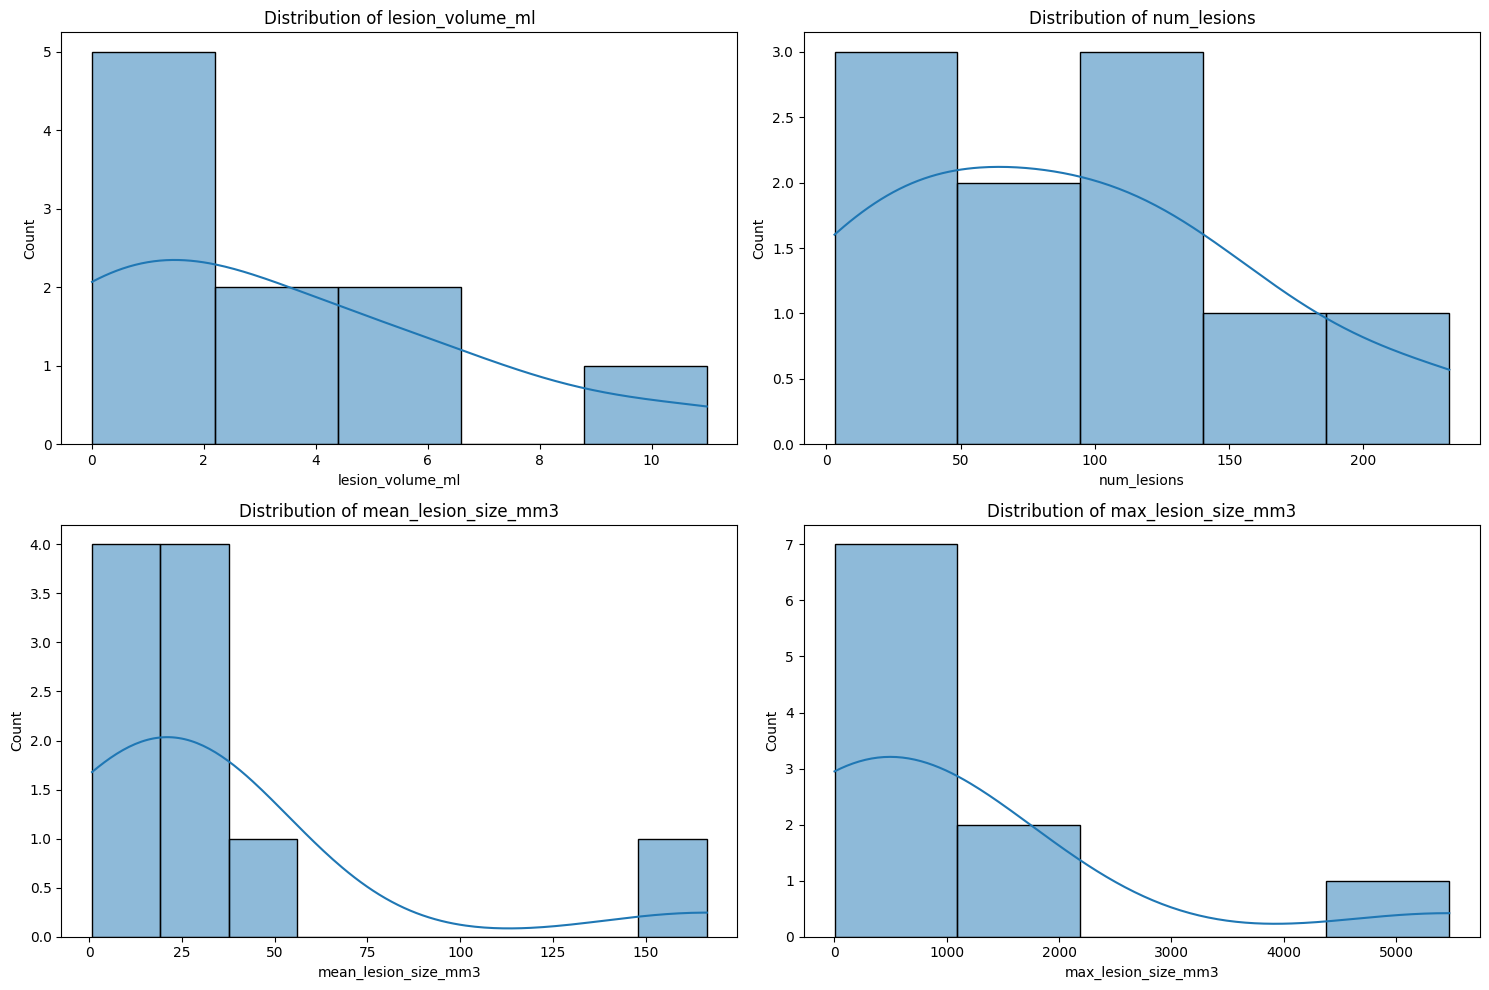

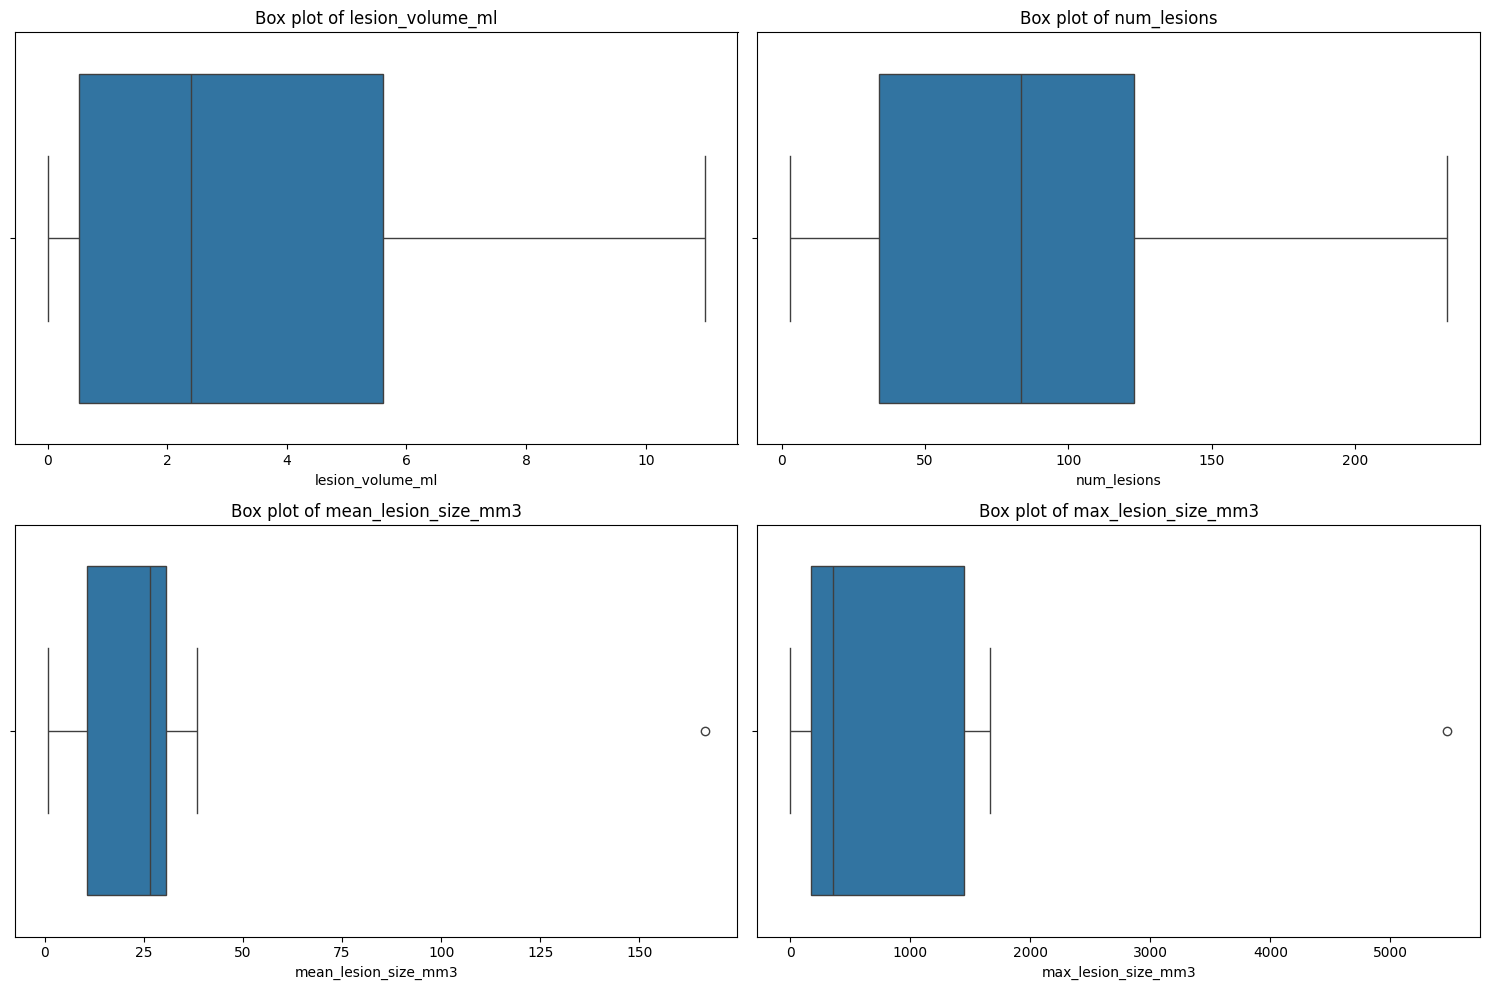

In [9]:
numerical_cols = ['lesion_volume_ml', 'num_lesions', 'mean_lesion_size_mm3', 'max_lesion_size_mm3']

plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df_features[col], kde=True)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x=df_features[col])
    plt.title(f'Box plot of {col}')

plt.tight_layout()
plt.show()

**Reasoning**:
The visualizations and summary statistics indicate potential outliers in the numerical feature columns, particularly `max_lesion_size_mm3`. Given the small dataset size (10 observations), removing outliers might significantly impact the data. Since the data is skewed and contains outliers, a log transformation can help normalize the distributions and mitigate the effect of extreme values. I will apply log transformation to the skewed columns (`lesion_volume_ml`, `mean_lesion_size_mm3`, `max_lesion_size_mm3`) and then display the summary statistics and check for missing values again.



In [10]:
# Apply log transformation to skewed columns to handle outliers and skewness
# Adding a small constant (1) to handle potential zero values before log transformation
for col in ['lesion_volume_ml', 'mean_lesion_size_mm3', 'max_lesion_size_mm3']:
    df_features[f'{col}_log'] = np.log1p(df_features[col])

print("📊 Summary statistics after log transformation:")
display(df_features.describe())

print("\n🔍 Missing values after log transformation:")
display(df_features.isnull().sum())

📊 Summary statistics after log transformation:


,lesion_volume_ml,num_lesions,mean_lesion_size_mm3,max_lesion_size_mm3,lesion_volume_ml_log,mean_lesion_size_mm3_log,max_lesion_size_mm3_log
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,3.351645,88.800000,35.327927,1087.083769,1.145978,3.020982,5.623551
std,3.576356,72.889262,47.616732,1660.016410,0.875876,1.189277,2.327491
min,0.002383,3.000000,0.794250,1.021179,0.002380,0.584587,0.703681
25%,0.517416,34.000000,10.627381,172.144682,0.409115,2.399837,5.122717
50%,2.402822,83.500000,26.603434,357.550154,1.208935,3.317584,5.864408
75%,5.613734,122.750000,30.709006,1445.835248,1.875960,3.456443,7.259591
max,10.984483,232.000000,166.431565,5472.839243,2.483613,5.120575,8.607736



🔍 Missing values after log transformation:


,0
patient_id,0
timepoint,0
lesion_volume_ml,0
num_lesions,0
mean_lesion_size_mm3,0
max_lesion_size_mm3,0
lesion_volume_ml_log,0
mean_lesion_size_mm3_log,0
max_lesion_size_mm3_log,0


## Save features

### Subtask:
Save the final DataFrame containing the classical features to a CSV file for later use.


**Reasoning**:
Save the final dataframe to a CSV file as instructed.



In [11]:
# Save the DataFrame to a CSV file without the index
output_csv_path = 'classical_features.csv'
df_features.to_csv(output_csv_path, index=False)

print(f"✅ Classical features saved to {output_csv_path}")

✅ Classical features saved to classical_features.csv


## Summary:

### Data Analysis Key Findings

*   Classical features, including lesion volume (mL), number of lesions, mean lesion size (mm³), and maximum lesion size (mm³), were successfully extracted for each patient and timepoint.
*   The initial extracted features DataFrame (`df_features`) contained no missing values.
*   Histograms and box plots revealed that the features, particularly `max_lesion_size_mm3`, exhibited skewed distributions and potential outliers.
*   A log transformation (`np.log1p`) was applied to the skewed columns (`lesion_volume_ml`, `mean_lesion_size_mm3`, and `max_lesion_size_mm3`) to address skewness and mitigate outlier influence, creating new log-transformed columns.
*   The final DataFrame containing both original and log-transformed classical features was successfully saved to a CSV file named `classical_features.csv`.

### Insights or Next Steps

*   The log-transformed features are better suited for statistical modeling techniques that assume normally distributed data or are sensitive to outliers.
*   This extracted and cleaned feature set is now ready for further analysis, such as tracking lesion changes over time, comparing feature values between patient groups, or using them as inputs for predictive models.


🖼️ Visualizando ejemplos de imágenes FLAIR y máscaras de lesiones...

Paciente: MSSEG2016_TrainingData_Patient_01
  Shape FLAIR: (240, 256, 512)
  Shape Mask: (240, 256, 512)


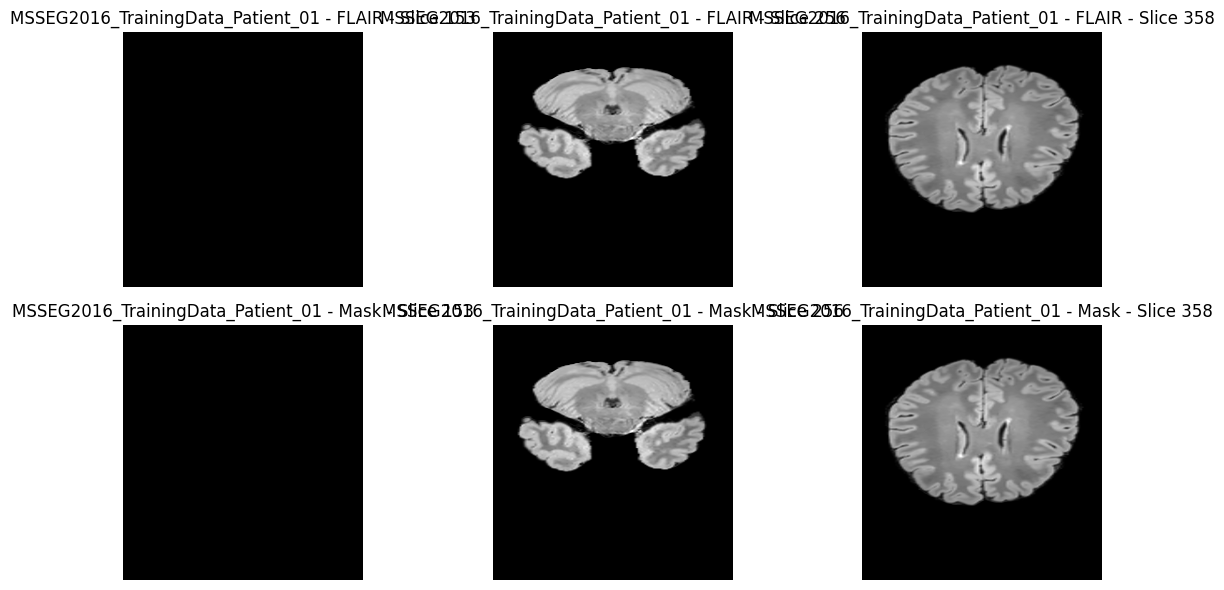

Paciente: MSSEG2016_TrainingData_Patient_02
  Shape FLAIR: (240, 256, 512)
  Shape Mask: (240, 256, 512)


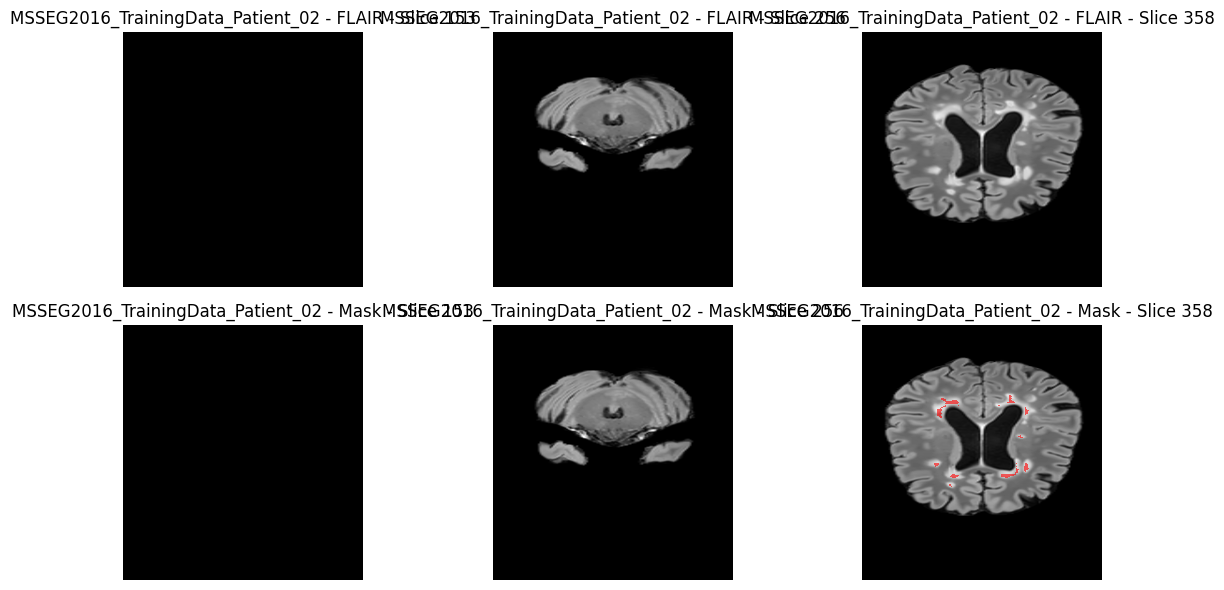

Paciente: MSSEG2016_TrainingData_Patient_03
  Shape FLAIR: (240, 256, 512)
  Shape Mask: (240, 256, 512)


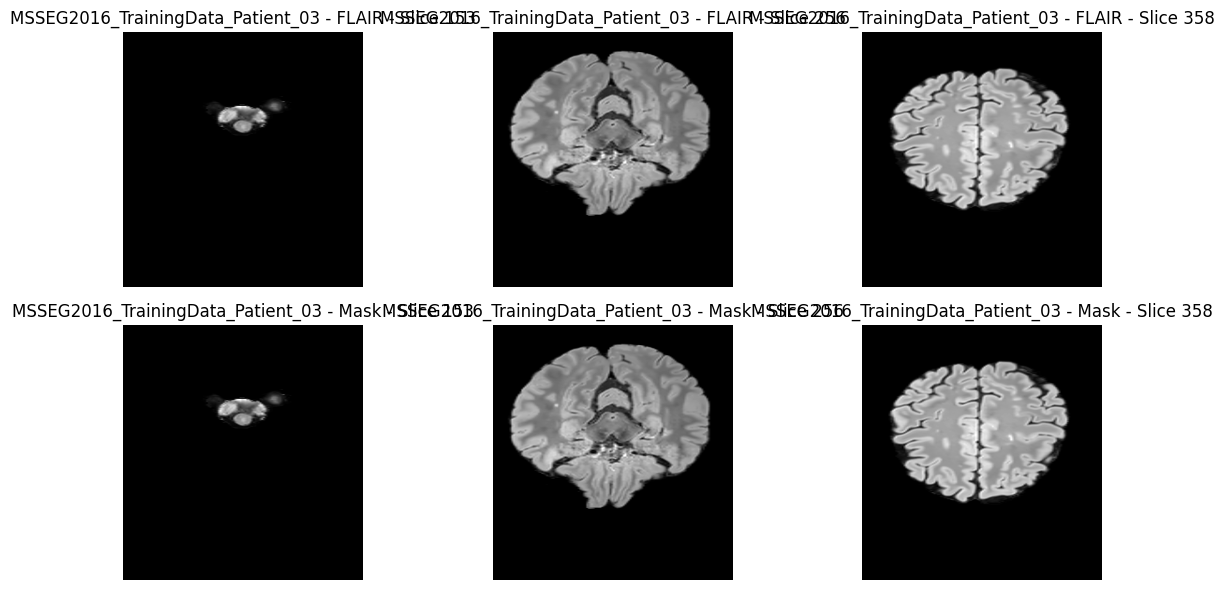

In [18]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_organized is available from previous steps
if 'df_organized' in locals() and not df_organized.empty:
    print("🖼️ Visualizando ejemplos de imágenes FLAIR y máscaras de lesiones...\n")

    # Select a few examples (e.g., first 3 patients)
    examples_to_show = min(3, len(df_organized))
    example_patients = df_organized.head(examples_to_show)

    for index, row in example_patients.iterrows():
        patient_id = row['patient_id']
        flair_path = row['flair']
        mask_path = row['mask']

        try:
            # Load the FLAIR image and mask
            flair_img = nib.load(flair_path)
            mask_img = nib.load(mask_path)

            flair_data = flair_img.get_fdata()
            mask_data = mask_img.get_fdata()

            print(f"Paciente: {patient_id}")
            print(f"  Shape FLAIR: {flair_data.shape}")
            print(f"  Shape Mask: {mask_data.shape}")

            # Select a few slices to display (e.g., middle slices)
            num_slices = flair_data.shape[2] # Assuming axial slices are along the third dimension
            slice_indices = [int(num_slices * 0.3), int(num_slices * 0.5), int(num_slices * 0.7)]

            plt.figure(figsize=(12, 6))

            for i, slice_idx in enumerate(slice_indices):
                # Display FLAIR slice
                plt.subplot(2, examples_to_show, i + 1)
                plt.imshow(flair_data[:, :, slice_idx].T, cmap='gray', origin='lower')
                plt.title(f'{patient_id} - FLAIR - Slice {slice_idx}')
                plt.axis('off')

                # Display Mask slice (overlayed)
                plt.subplot(2, examples_to_show, i + examples_to_show + 1)
                plt.imshow(flair_data[:, :, slice_idx].T, cmap='gray', origin='lower') # Background
                mask_slice = np.ma.masked_where(mask_data[:, :, slice_idx].T == 0, mask_data[:, :, slice_idx].T)
                plt.imshow(mask_slice, cmap='autumn', origin='lower', alpha=0.6) # Overlay mask
                plt.title(f'{patient_id} - Mask - Slice {slice_idx}')
                plt.axis('off')

            plt.tight_layout()
            plt.show()

        except FileNotFoundError:
            print(f"❌ Error: Archivo no encontrado para el paciente {patient_id}. Saltando...")
        except Exception as e:
            print(f"❌ Ocurrió un error al visualizar para el paciente {patient_id}: {e}. Saltando...")

else:
    print("❌ El DataFrame 'df_organized' no está disponible o está vacío. Por favor, ejecuta la celda de organización de datos primero.")

In [17]:
import pandas as pd

csv_path = '/content/classical_features.csv'

try:
    # Load the CSV file into a pandas DataFrame
    df_classical_features = pd.read_csv(csv_path)

    print(f"✅ Archivo '{csv_path}' cargado correctamente.")

    print("\n📋 Primeros registros del DataFrame:")
    display(df_classical_features.head())

    print("\n📊 Información general del DataFrame:")
    display(df_classical_features.info())

    print("\n📊 Estadísticas descriptivas del DataFrame:")
    display(df_classical_features.describe())

except FileNotFoundError:
    print(f"❌ Error: El archivo '{csv_path}' no fue encontrado.")
except Exception as e:
    print(f"❌ Ocurrió un error al cargar o explorar el archivo CSV: {e}")

✅ Archivo '/content/classical_features.csv' cargado correctamente.

📋 Primeros registros del DataFrame:


,patient_id,timepoint,lesion_volume_ml,num_lesions,mean_lesion_size_mm3,max_lesion_size_mm3,lesion_volume_ml_log,mean_lesion_size_mm3_log,max_lesion_size_mm3_log
0,MSSEG2016_TrainingData_Patient_01,timepoint_01,0.002383,3,0.794250,1.021179,0.002380,0.584587,0.703681
1,MSSEG2016_TrainingData_Patient_02,timepoint_01,3.879026,125,31.032210,1013.386195,1.584946,3.466742,6.922039
2,MSSEG2016_TrainingData_Patient_03,timepoint_01,1.805104,101,17.872321,253.428406,1.031441,2.937696,5.539019
3,MSSEG2016_TrainingData_Patient_04,timepoint_01,10.984483,66,166.431565,5472.839243,2.483613,5.120575,8.607736
4,MSSEG2016_TrainingData_Patient_05,timepoint_01,3.000540,116,25.866724,424.345237,1.386429,3.290888,6.052901



📊 Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   patient_id                10 non-null     object 
 1   timepoint                 10 non-null     object 
 2   lesion_volume_ml          10 non-null     float64
 3   num_lesions               10 non-null     int64  
 4   mean_lesion_size_mm3      10 non-null     float64
 5   max_lesion_size_mm3       10 non-null     float64
 6   lesion_volume_ml_log      10 non-null     float64
 7   mean_lesion_size_mm3_log  10 non-null     float64
 8   max_lesion_size_mm3_log   10 non-null     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 852.0+ bytes


None


📊 Estadísticas descriptivas del DataFrame:


,lesion_volume_ml,num_lesions,mean_lesion_size_mm3,max_lesion_size_mm3,lesion_volume_ml_log,mean_lesion_size_mm3_log,max_lesion_size_mm3_log
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,3.351645,88.800000,35.327927,1087.083769,1.145978,3.020982,5.623551
std,3.576356,72.889262,47.616732,1660.016410,0.875876,1.189277,2.327491
min,0.002383,3.000000,0.794250,1.021179,0.002380,0.584587,0.703681
25%,0.517416,34.000000,10.627381,172.144682,0.409115,2.399837,5.122717
50%,2.402822,83.500000,26.603434,357.550154,1.208935,3.317584,5.864408
75%,5.613734,122.750000,30.709006,1445.835248,1.875960,3.456443,7.259591
max,10.984483,232.000000,166.431565,5472.839243,2.483613,5.120575,8.607736
